In [1]:
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
# For data manipulation
import pandas as pd
import numpy as np
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For prediction
from tqdm import tqdm

from extract_zip import extract_zip_to_memory # function for decompressing zip in memory
from PIL import Image, ImageOps # image handling
from io import BytesIO # image handling

# for the CNN
import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential

from sklearn import preprocessing

basepath = "/mnt/datasets/plankton/flowcam/"

Using TensorFlow backend.


In [2]:
imgFiles = extract_zip_to_memory(basepath + "imgs.zip")

In [3]:
# label dataset
labelsDF = pd.read_csv(basepath + 'meta.csv')

In [4]:
labelsDF['objid'] = labelsDF['objid'].astype(np.int64, errors='ignore')
labelsDF['level1'] = labelsDF['level1'].fillna('No_level1_name')
labelsDF['level2'] = labelsDF['level2'].fillna('No_level2_name')

print(labelsDF.isnull().sum().any())

False


In [5]:
print('Nr. of unique level1 names:', labelsDF['level1'].nunique())
print('Nr. of unique level2 names:', labelsDF['level2'].nunique())
print('Nr. of unique names  total:', labelsDF['unique_name'].nunique())

Nr. of unique level1 names: 57
Nr. of unique level2 names: 40
Nr. of unique names  total: 103


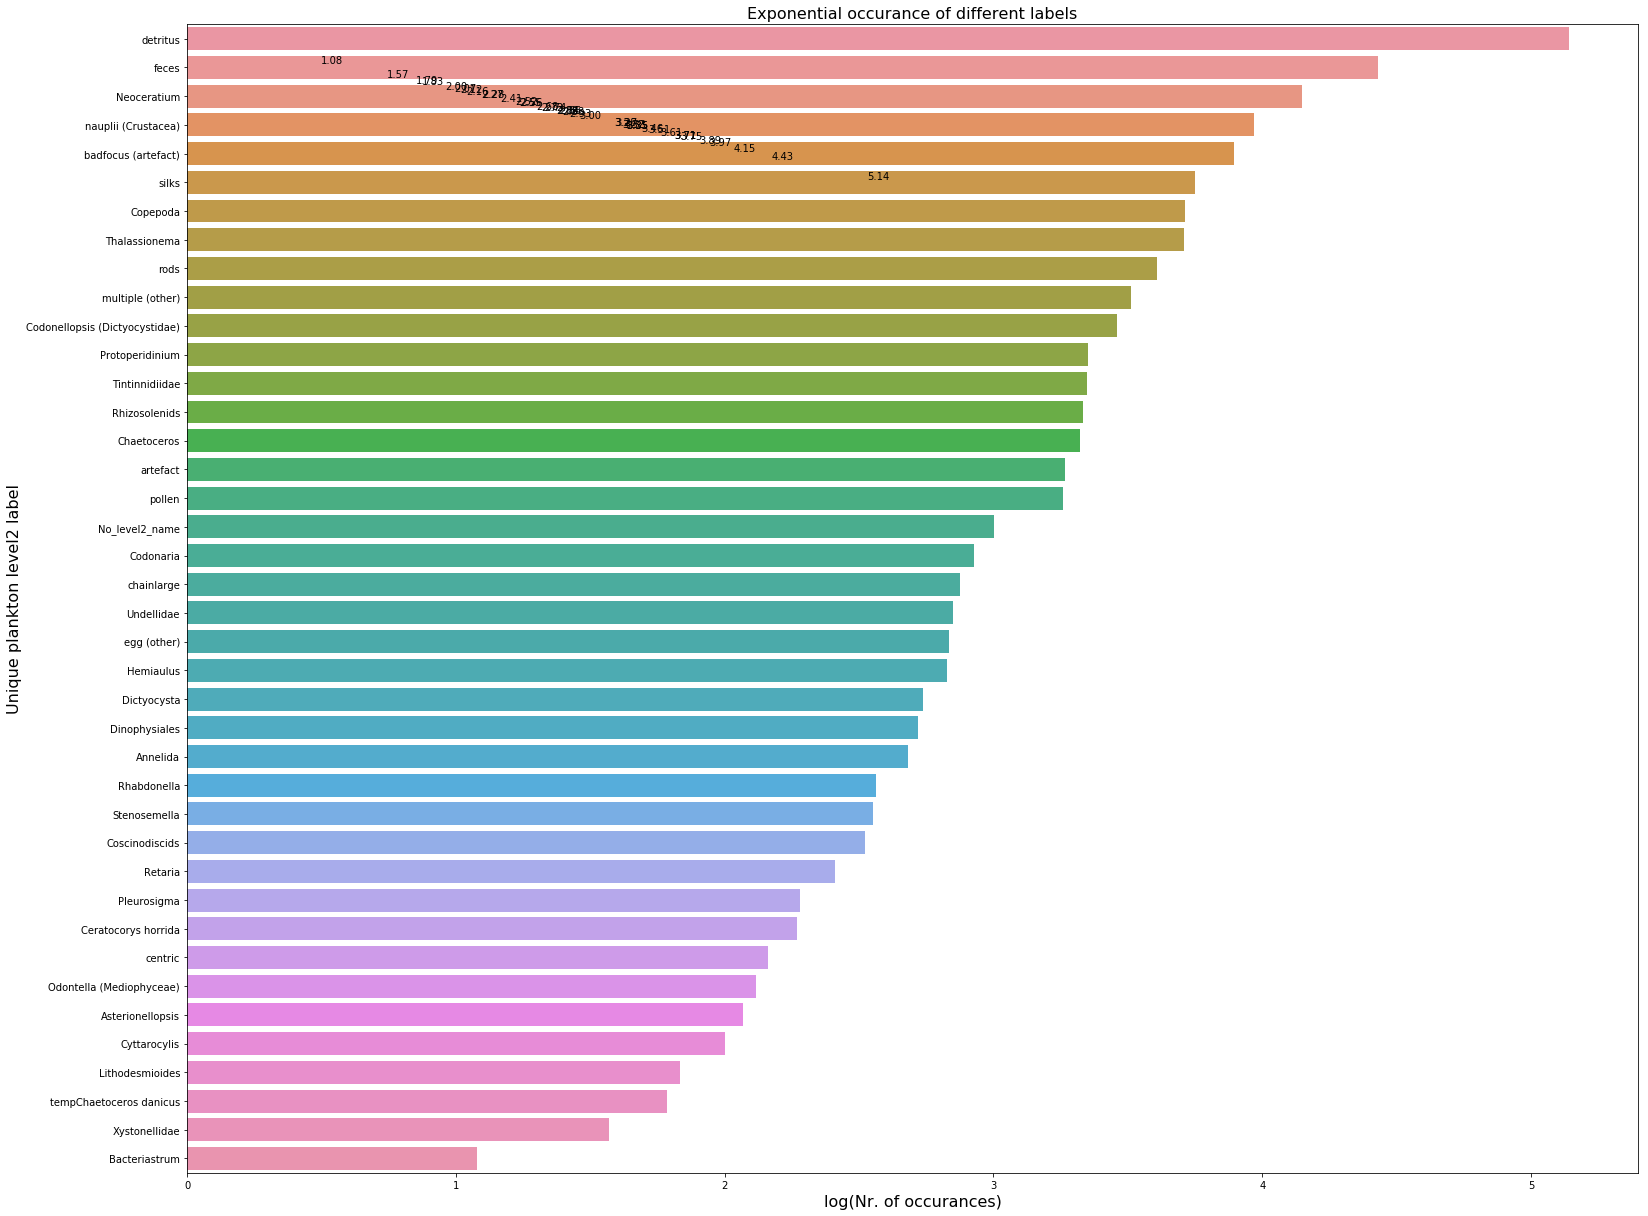

In [6]:
number_unique_names = labelsDF.groupby('level2', as_index=True)['id'].count()
number_unique_names.sort_values(inplace=True, ascending=False)

figure, ax = plt.subplots(figsize=(23,17))
ax = sns.barplot(y=number_unique_names.index, x=np.log10(number_unique_names.values))
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

'''for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')'''

for p in ax.patches:
    ax.annotate(format(p.get_width(),'.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_width()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.ylabel('Unique plankton level2 label', fontsize= 16)
plt.xlabel('log(Nr. of occurances)', fontsize= 16)
plt.title('Exponential occurance of different labels', fontsize=16)
plt.tight_layout()

In [7]:
# Fetching the object ids that pertain to specific labels
# And fetching the level2 labels of the categories we want to duplicate
unique_names = list(number_unique_names.index)
original_objid_dict = {}
labels_to_multiply = []

for name in unique_names:
    objid_labels = list(labelsDF.loc[labelsDF['level2'] == name, 'objid'])
    original_objid_dict.update({name : objid_labels})
    print('Label:', name[:4], 'has', len(objid_labels), 'object IDs.')
    # Find labels that we want to generate more data within
    if len(objid_labels) < 1000:
        labels_to_multiply.append(name)

Label: detr has 138439 object IDs.
Label: fece has 26936 object IDs.
Label: Neoc has 14014 object IDs.
Label: naup has 9293 object IDs.
Label: badf has 7848 object IDs.
Label: silk has 5629 object IDs.
Label: Cope has 5141 object IDs.
Label: Thal has 5117 object IDs.
Label: rods has 4044 object IDs.
Label: mult has 3261 object IDs.
Label: Codo has 2888 object IDs.
Label: Prot has 2256 object IDs.
Label: Tint has 2227 object IDs.
Label: Rhiz has 2160 object IDs.
Label: Chae has 2105 object IDs.
Label: arte has 1849 object IDs.
Label: poll has 1821 object IDs.
Label: No_l has 1003 object IDs.
Label: Codo has 845 object IDs.
Label: chai has 751 object IDs.
Label: Unde has 710 object IDs.
Label: egg  has 685 object IDs.
Label: Hemi has 670 object IDs.
Label: Dict has 549 object IDs.
Label: Dino has 525 object IDs.
Label: Anne has 481 object IDs.
Label: Rhab has 367 object IDs.
Label: Sten has 357 object IDs.
Label: Cosc has 334 object IDs.
Label: Reta has 257 object IDs.
Label: Pleu has 19

In [8]:
# Checking if all the object IDs start with the number 3
truthS = labelsDF['objid'].astype(str)
truth2 = truthS[:5]
flag = True
for items in truth2.iteritems():
    if (items[1][:2] != '32'):
        flag = False
print(flag)

True


### Functions used for the autoloader and preprocessing

In [9]:
def strip(key):
    return int(key[5:-4])

def key_to_objid(list_of_keys):
    return [strip(key) for key in list_of_keys]

def reverse_strip(objid):
    return 'imgs/' + str(objid) + '.jpg'

def objid_to_key(list_of_objids):
    return [reverse_strip(objid) for objid in list_of_objids]

# Functions to preprocess images
def image_processing(key):
    desired_size = 972 # max of width and height in dataset
    im_orginal = Image.open(imgFiles[key])
    old_size = im_orginal.size  # old_size[0] is in (width, height) format
    
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im_scaled = im_orginal.resize(new_size) # scale up picture before padding to keep information
    
    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    im_padded = ImageOps.expand(im_scaled, padding, fill=255) # padding of scaled picture
    
    final_size = (40, 40) # input size for CNN
    im_final = im_padded.resize(final_size, resample=0) # resize to input size of CNN
    return np.array(im_final)

def fetch_label(key, lvl='level2'):
    return list(labelsDF[labelsDF['objid']==strip(key)][lvl])[0]

#print(fetch_label('imgs/32627324.jpg'))

In [10]:
img_keys = list(imgFiles.keys())
processed_imgs = {strip(key) : [image_processing(key), fetch_label(key)] for key in tqdm(img_keys)}

100%|██████████| 243610/243610 [07:24<00:00, 548.64it/s]


In [11]:
del imgFiles

In [23]:
def generate_new_object_ids(object_id):
    stripped_key = str(object_id)
    key_lr = int('8' + stripped_key[1:])
    key_ud = int('1' + stripped_key[1:])
    key_90 = int('2' + stripped_key[1:])
    key_180 = int('4' + stripped_key[1:])
    key_270 = int('5' + stripped_key[1:])
    key_t1 = int('6' + stripped_key[1:])
    key_t2 = int('7' + stripped_key[1:])
    return {'lr' : key_lr, 'ud' : key_ud, '90' : key_90, '180' : key_180,
                '270' : key_270, 't1' : key_t1, 't2' : key_t2}

def generate_duplicates(object_id, image_files=processed_imgs):
    # Fetching and making numpy array of original object
    img_np_array = image_files[object_id][0]

    # Generating copies of data using numpy functions for flipping, rotating and transposing
    img_flipped_ud = np.flip(img_np_array, 0)
    img_flipped_lr = np.flip(img_np_array, 1)
    img_rot_90 = np.rot90(img_np_array, k=1)
    img_rot_180 = np.rot90(img_np_array, k=2)
    img_rot_270 = np.rot90(img_np_array, k=3)
    img_tran_1 = np.transpose(img_np_array)
    img_tran_2 = np.flip(np.transpose(np.flip(img_np_array, 1)), 1)
    
    # Generating new keys
    key_dict = generate_new_object_ids(object_id)
    # Fetching label
    lbl = fetch_label(reverse_strip(object_id))
    # Updating dictionary of images with new data
    image_files.update({key_dict['ud'] : [img_flipped_ud, lbl], key_dict['lr'] : [img_flipped_lr, lbl], 
                      key_dict['90'] : [img_rot_90, lbl], key_dict['180'] : [img_rot_180, lbl], 
                      key_dict['270'] : [img_rot_270, lbl], key_dict['t1'] : [img_tran_1, lbl], 
                      key_dict['t2'] : [img_tran_2, lbl]})
    
    return image_files

testkey = 32606329
processed_imgs = generate_duplicates(testkey)
# print(imgFiles[testkey])
# print(fetch_labels([testkey]))

In [24]:
# Actually generate more data
total_nr = 0
for label in labels_to_multiply:
    object_ids = original_objid_dict[label]
    print('For label:', label[:4], 'we generate', len(object_ids)*8, 'new images')
    total_nr += len(object_ids)*8
    for objid in object_ids:
        processed_imgs = generate_duplicates(objid)
print('Total nr of new images produced:', total_nr)    

For label: Codo we generate 6760 new images
For label: chai we generate 6008 new images
For label: Unde we generate 5680 new images
For label: egg  we generate 5480 new images
For label: Hemi we generate 5360 new images
For label: Dict we generate 4392 new images
For label: Dino we generate 4200 new images
For label: Anne we generate 3848 new images
For label: Rhab we generate 2936 new images
For label: Sten we generate 2856 new images
For label: Cosc we generate 2672 new images
For label: Reta we generate 2056 new images
For label: Pleu we generate 1528 new images
For label: Cera we generate 1488 new images
For label: cent we generate 1160 new images
For label: Odon we generate 1048 new images
For label: Aste we generate 936 new images
For label: Cytt we generate 800 new images
For label: Lith we generate 544 new images
For label: temp we generate 488 new images
For label: Xyst we generate 296 new images
For label: Bact we generate 96 new images
Total nr of new images produced: 60632


In [25]:
def train_test_val_split():
    train_objids = []
    test_objids = [] 
    val_objids = []
    for label in unique_names:
        object_ids = original_objid_dict[label]
        number_train = int(len(object_ids)*0.6)
        number_test = int(len(object_ids)*0.2)
        train_objids += object_ids[:number_train]
        test_objids += object_ids[number_train:(number_train + number_test)]
        val_objids += object_ids[(number_train + number_test):]
    return train_objids, test_objids, val_objids


### Dividing data into test and training

In [26]:
img_files_objids = list(processed_imgs.keys())
# Shuffle order of keys
img_files_objids = random.sample(img_files_objids, len(img_files_objids))


# Divide data into trainingand test data, by keys
from sklearn.model_selection import train_test_split
test_size = 0.10
objids_train, objids_test = train_test_split(img_files_objids, test_size = test_size)

# Make small test and validation set, to explore models. 
size_small_train, size_small_validation = 40000, 10000
small_objids_train = objids_train[size_small_validation:(size_small_validation + size_small_train)]
small_objids_validation = objids_test[:size_small_validation]

train_objids, test_objids, val_objids = train_test_val_split()

train_objids = random.sample(train_objids, len(train_objids))
test_objids = random.sample(test_objids, len(test_objids))
val_objids = random.sample(val_objids, len(val_objids))

In [27]:
def autoloader(list_of_object_ids):
    X = np.array([processed_imgs[object_id][0] for object_id in list_of_object_ids])
    y = np.array([processed_imgs[object_id][1] for object_id in list_of_object_ids])
    
    le = LabelEncoder()
    y = le.fit_transform(y)
    # one-hot encode target column
    y = to_categorical(y)

    # Reshape input data to account for images only being greyscale
    X = X.reshape(len(list_of_object_ids), 40, 40, 1)
    return X, y

In [28]:
# We want to label-encode the different categories so we can one-hot encode them.  
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Fetch pictures and labels, corresponding to keys.
# train
X_train, y_train = autoloader(train_objids)
# test
X_test, y_test = autoloader(test_objids)

X_val, y_val = autoloader(val_objids)

In [29]:
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('y_val shape:', y_val.shape)

y_train shape: (146151, 40)
y_test shape: (48708, 40)
y_val shape: (48751, 40)


### Parameters for keras CNN

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras.backend as K
import tensorflow as tf

# input dimensions
input_shape = (40, 40, 1)
# network parameters 
batch_size = 64
classes = labelsDF.level2.unique()
num_classes = labelsDF.level2.nunique()
epochs = 1 # Further Fine Tuning can be done

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1 = 2*((precision*recall)/(precision+recall+K.epsilon()))
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

### Architectures
 
- input -> (conv -> pool)*2 -> fc -> softmax
- input -> (conv -> conv -> pool)*3-4 -> fc -> fc -> softmax

#### To further explore
Data augementation of pictures with rare labels
- https://medium.com/@arindambaidya168/https-medium-com-arindambaidya168-using-keras-imagedatagenerator-b94a87cdefad
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [18]:
# Keras CNN model
model = Sequential()

# add first  layer
#model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add second layer
#model.add(BatchNormalization())
#model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add third layer
#model.add(BatchNormalization())
#model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
#model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))



# add flatten layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))

# add last layer
model.add(Dense(num_classes, activation='softmax'))

# complile the model and view its architecur
model.compile(loss=keras.losses.categorical_crossentropy,  optimizer="Adam", metrics=['accuracy', f1])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 38, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               524416    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

In [19]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test))

Train on 146151 samples, validate on 48708 samples
Epoch 1/1
146151/146151 [==============================] - 85s 581us/step - loss: 7.0889 - acc: 0.5601 - f1: 0.5601 - val_loss: 6.9561 - val_acc: 0.5684 - val_f1: 0.5684


In [20]:
from sklearn.metrics import f1_score

test_predict = model.predict(X_test)
test_f1 = f1_score(y_test, test_predict, average="macro", labels=np.unique(test_predict))

val_predict = model.predict(X_val)
val_f1 = f1_score(y_val, val_predict, average="macro", labels=np.unique(val_predict))

print("Test F1 Score: ", test_f1)
print("Val F1 Score: ", val_f1)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test F1 Score:  0.018120950323974084
Val F1 Score:  0.018111590790162217


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
